In [1]:
import os
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import gc

In [2]:
class IndianDrivingDataset(Dataset):

    def __init__(self, img_dir, label_dir):

        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_list = []
        self.label_list = []
        for i in os.listdir(self.img_dir):
            temp = i.split('_')
            self.img_list.append('image_archive/image_'+temp[1])
            self.label_list.append('mask_archive/mask_'+temp[1])
        self.centre_crop = transforms.CenterCrop((512,512))

    def __len__(self):

        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):

        img_path= self.img_list[idx]
        label_path = self.label_list[idx]
        img = Image.open(img_path)
        img_tensor = torch.from_numpy(np.array(img))
        img_tensor = img_tensor.permute(2, 0, 1)
        img_tensor = img_tensor.type(torch.float32) / 255.0
        img_tensor = self.centre_crop(img_tensor)
        label = Image.open(label_path)
        label = np.array(label)
        label_tensor = torch.from_numpy(np.array(label))
        label_tensor = self.centre_crop(label_tensor)
        return img_tensor, label_tensor

In [3]:
data = IndianDrivingDataset('image_archive','mask_archive')
print(len(data))

6982


In [4]:
train_size = int(0.7 * len(data))
test_size = len(data) - train_size

train_set, test_set = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=8)
test_loader = DataLoader(test_set, batch_size=2, shuffle=False, num_workers=8)

print(len(train_set),len(test_set))

4887 2095


In [5]:
counter=100

In [6]:
pixel_count_unique = {}
for i in range(26):
    pixel_count_unique[i] = 0
pixel_count_unique[255] = 0


for image, label in train_loader:
    counter-=2
    if(counter==0):
        break
    temp = label.numpy()
    temp = np.unique(label[0])
    for i in temp:
        pixel_count_unique[i]+=1
    del image, temp
    temp = np.unique(label[1])
    for i in temp:
        pixel_count_unique[i]+=1
    del temp, label
    gc.collect()

print(pixel_count_unique)


{0: 97, 1: 83, 2: 17, 3: 37, 4: 57, 5: 80, 6: 78, 7: 5, 8: 58, 9: 76, 10: 52, 11: 24, 12: 64, 13: 52, 14: 40, 15: 19, 16: 13, 17: 65, 18: 29, 19: 4, 20: 88, 21: 95, 22: 80, 23: 8, 24: 94, 25: 88, 255: 58}


{'road': 97, 'drivable fallback': 83, 'sidewalk': 17, 'non-drivable fallback': 37, 'person': 57, 'rider': 80, 'motorcycle': 78, 'bicycle': 5, 'auto-rickshaw': 58, 'car': 76, 'truck': 52, 'bus': 24, 'vehicle fallback': 64, 'curb': 52, 'wall': 40, 'fence': 19, 'guard rail': 13, 'billboard': 65, 'traffic sign': 29, 'traffic light': 4, 'pole': 88, 'obs fallback': 95, 'building': 80, 'bridge': 8, 'vegetation': 94, 'sky': 88, 'unlabelled': 58}


<BarContainer object of 27 artists>

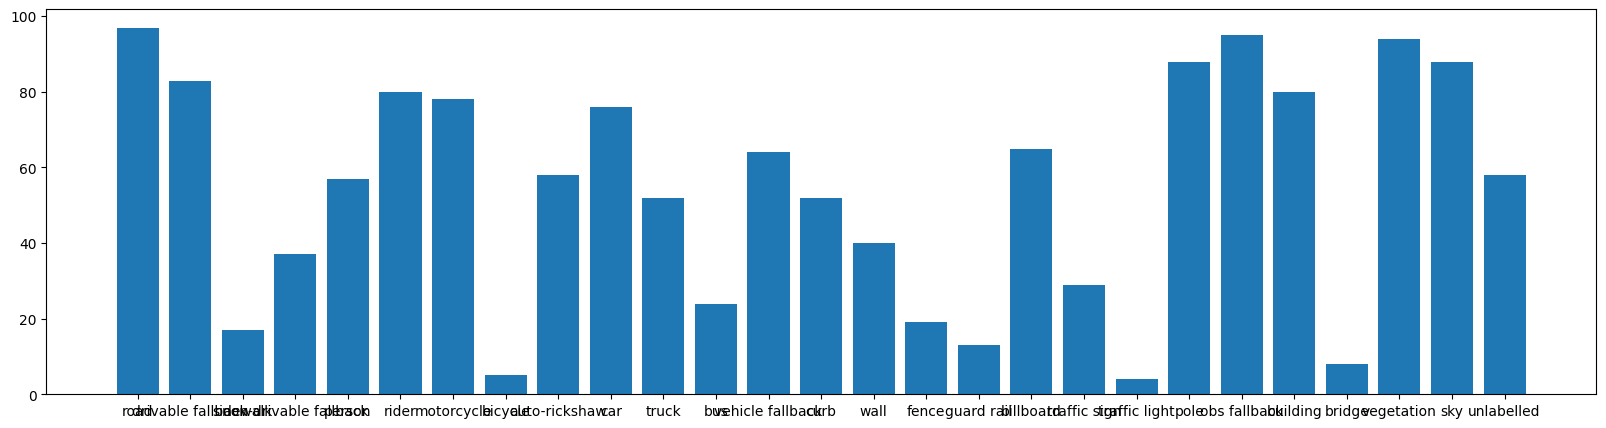

In [7]:
classes = ('road', 'drivable fallback', 'sidewalk', 'non-drivable fallback', 'person', 'rider', 'motorcycle',
'bicycle', 'auto-rickshaw', 'car', 'truck', 'bus', 'vehicle fallback', 'curb', 'wall', 'fence', 'guard rail',
'billboard', 'traffic sign', 'traffic light', 'pole', 'obs fallback', 'building', 'bridge', 'vegetation', 'sky',
'unlabelled')

temp_list = [i for i in range(26)]
temp_list.append(255)

label_map = {}
for i, j in enumerate(classes):
    if(i==26):
        break
    label_map[j] = pixel_count_unique[i]
label_map['unlabelled'] = pixel_count_unique[255]
print(label_map)

fig = plt.figure(figsize = (20, 5))
plt.bar(list(label_map.keys()), list(label_map.values()))

This distribution representation of the number of images having that class mask. Not the number of pixels of each class, but whether that class is present or not.

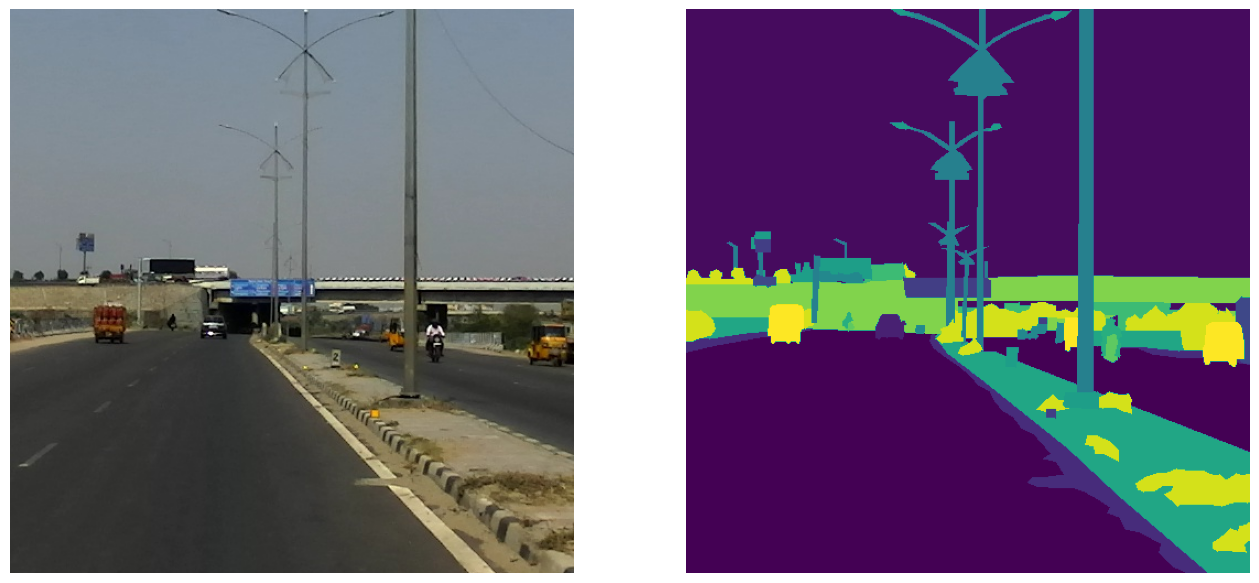

In [8]:
img, label = data[0]

plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.imshow(img.permute((1, 2, 0))) 
plt.axis('off')

plt.subplot(1,2,2)
im = plt.imshow(label*31)
plt.axis('off')

plt.show()

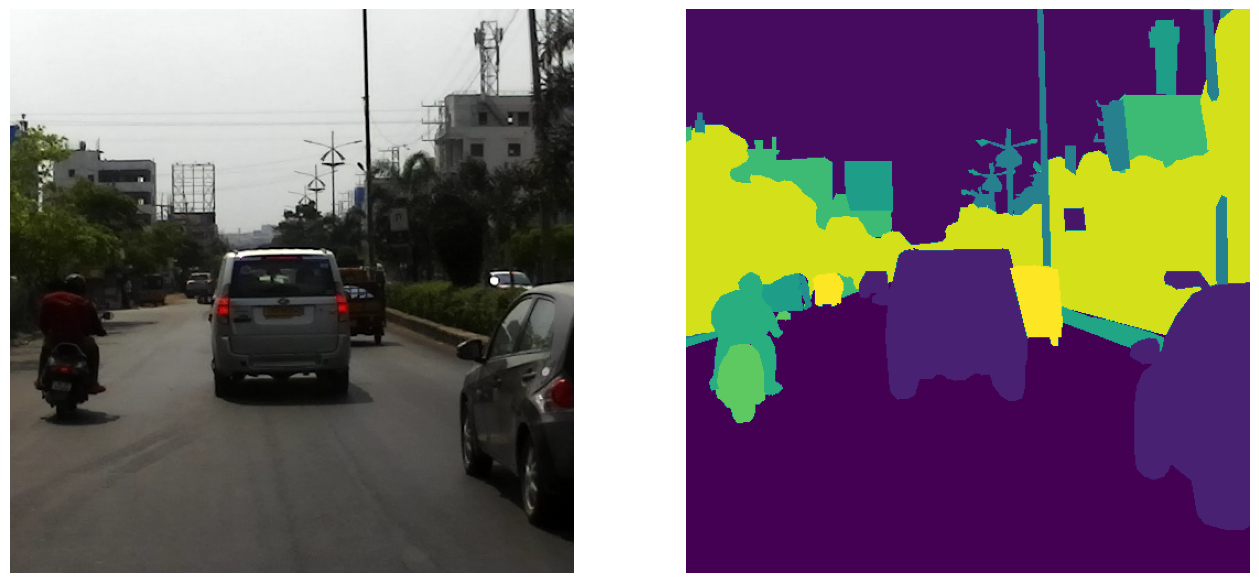

In [9]:
img, label = data[1]

plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.imshow(img.permute((1, 2, 0))) 
plt.axis('off')

plt.subplot(1,2,2)
im = plt.imshow(label*31)
plt.axis('off')

plt.show()

In [10]:
import network

model = network.modeling.__dict__['deeplabv3plus_mobilenet'](num_classes=19, output_stride=8)
model.load_state_dict( torch.load('best_deeplabv3plus_mobilenet_cityscapes_os16.pth', map_location='cpu')['model_state'])

<All keys matched successfully>

In [11]:
id_dict = {'road':0, 'sidewalk':1, 'building':2, 'wall':3, 'fence':4, 'pole':5, 'traffic light':6, 'traffic sign':7, 'vegetation':8, 'terrain':9, 'sky':10, 'person':11, 'rider':12, 'car':13,
           'truck':14, 'bus':15, 'train':16, 'motorcycle':17, 'bicycle':18, 'unlabelled': 255}

class_dict = {}

for i in id_dict:
    class_dict[id_dict[i]] = i
# this on what mobilenet model was trained on.

converted_dict = {0:0, 1:0, 2:1, 3:9, 4:11, 5:12, 6:17, 7:18, 8:13, 9:13, 10:14, 11:15, 12:15, 13:3, 14:3, 15:4, 16:4, 17:7, 18:7, 19:6, 20:5, 21:5, 22:2, 23:2, 24:8, 25:10, 255:255}

In [12]:
def calculate_mAP(seg_gt, seg_pred, num_classes=19):
    list_precision = []
    list_recall = []

    avg_precision = 0.0
    for class_id in range(num_classes):
        class_gt = (seg_gt == class_id).astype(np.float32)
        class_pred = (seg_pred == class_id).astype(np.float32)

        true_positives = np.sum(class_gt * class_pred)
        false_positives = np.sum(class_pred) - true_positives
        false_negatives = np.sum(class_gt) - true_positives

        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (true_positives + false_negatives + 1e-8)
        list_precision.append(precision)
        list_recall.append(recall)

        avg_precision += precision

    mAP = avg_precision / num_classes
    return mAP, list_precision, list_recall

def calculate_mIoU(seg_gt, seg_pred, num_classes=19):
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)
    for class_id in range(num_classes):
        class_gt = (seg_gt == class_id).astype(np.float32)
        class_pred = (seg_pred == class_id).astype(np.float32)

        intersection[class_id] = np.sum(class_gt * class_pred)
        union[class_id] = np.sum(class_gt) + np.sum(class_pred) - intersection[class_id]

    IoU = intersection / (union + 1e-8)
    mIoU = np.mean(IoU)
    return IoU

In [13]:
num_counter = 0
pixel_accuracy = 0
dice_coeff = 0
total_mAP = 0

total_mIoU = {}
total_precision = {}
total_recall = {}
for i in range(19):
    total_mIoU[i] = (0,0)
    total_precision[i] = (0,0)
    total_recall[i] = (0,0)

In [14]:
def visualise(pred, label):
    plt.figure(figsize=(16,12))

    plt.subplot(1,2,1)
    im = plt.imshow(pred)
    plt.axis('off')

    plt.subplot(1,2,2)
    im = plt.imshow(label)
    plt.axis('off')

    plt.show()
    

In [15]:
def metric_func(pred, label, flag=False):
    global num_counter, pixel_accuracy, dice_coeff, total_mIoU, total_mAP, total_precision, total_recall
    num_counter+=1
    for i in range(512):
        for j in range(512):
            label[i,j] = converted_dict[label[i,j]]

    pixel_wise_accuracy = np.mean(pred == label)
    intersection = np.sum(pred * label)
    union = np.sum(pred) + np.sum(label)
    dice_coefficient = (2.0 * intersection) / union
    mAP, precision, recall = calculate_mAP(label,pred)
    mIoU = calculate_mIoU(label,pred)
    if(flag):
        print(mIoU)
    if(flag):
        visualise(pred, label)
    for i, j in enumerate(mIoU):
        if j!=0:
            a, b = total_mIoU[i]
            a+=j
            b+=1
            total_mIoU[i] = (a,b)
    pixel_accuracy += pixel_wise_accuracy
    dice_coeff += dice_coefficient
    total_mAP += mAP
    for i, j in enumerate(precision):
        if j!=0:
            a, b = total_precision[i]
            a+=j
            b+=1
            total_precision[i] = (a,b)
    for i, j in enumerate(recall):
        if j!=0:
            a, b = total_recall[i]
            a+=j
            b+=1
            total_recall[i] = (a,b)

[0.79304416 0.         0.         0.28104575 0.         0.05156059
 0.         0.         0.68857855 0.         0.04707823 0.
 0.         0.50201623 0.         0.         0.         0.05205679
 0.        ]


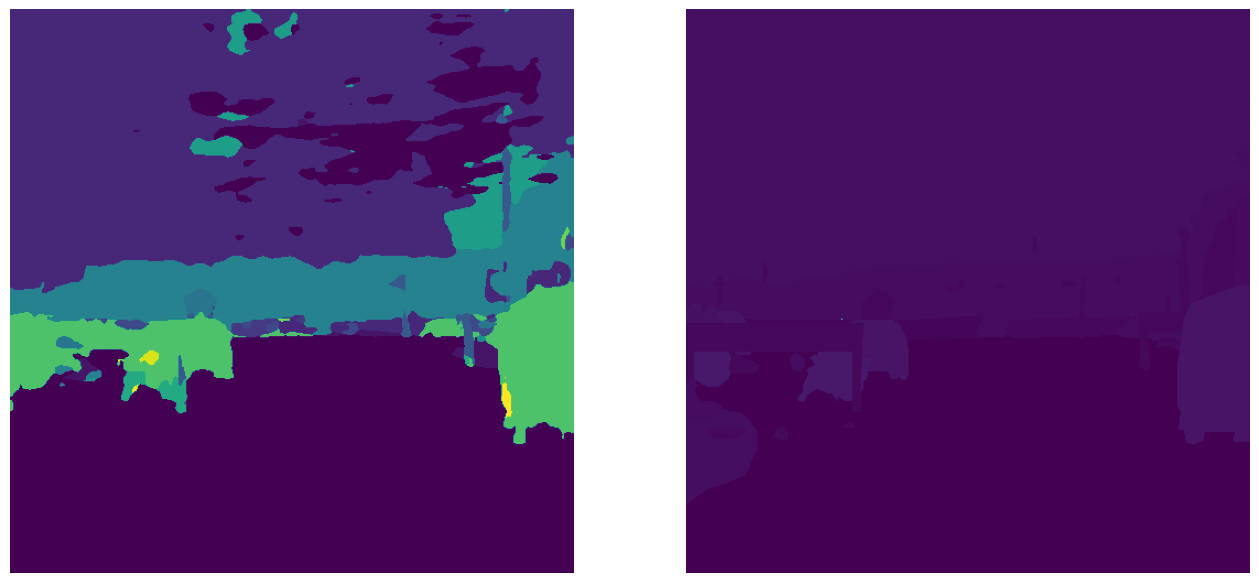

[0.85207948 0.         0.         0.         0.63480554 0.45793896
 0.         0.01432408 0.74140703 0.29914117 0.55673493 0.06079235
 0.         0.36861212 0.         0.         0.         0.
 0.        ]


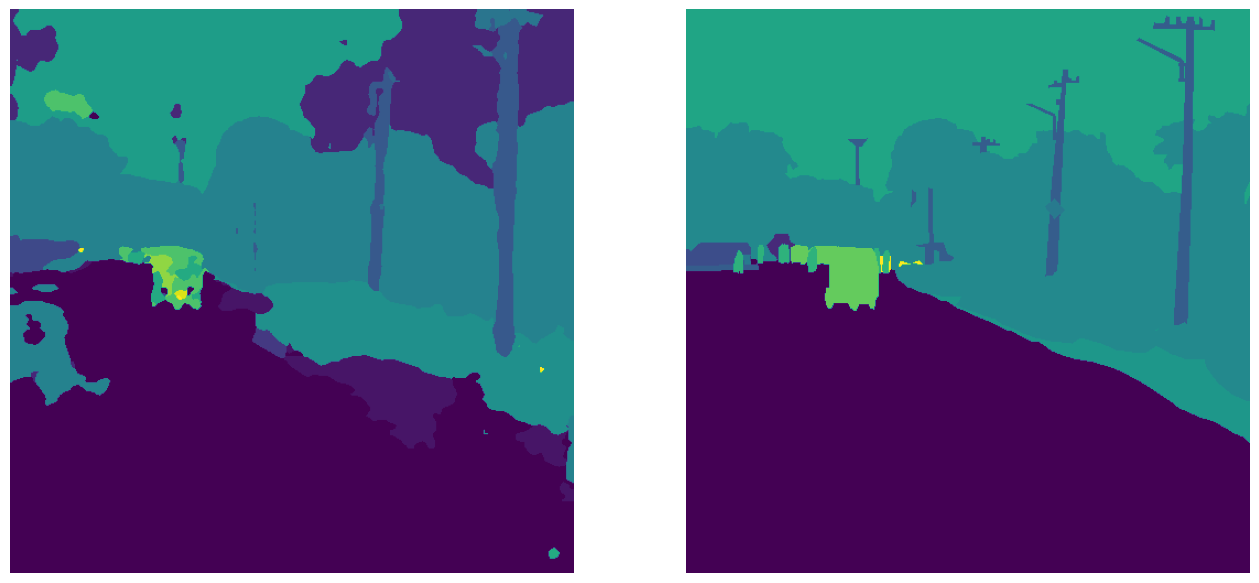

[9.56742560e-01 0.00000000e+00 8.63298551e-04 0.00000000e+00
 0.00000000e+00 8.80615211e-02 0.00000000e+00 0.00000000e+00
 6.51431289e-01 0.00000000e+00 7.32168097e-01 0.00000000e+00
 2.91075715e-01 7.13381659e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.73236382e-01 0.00000000e+00]


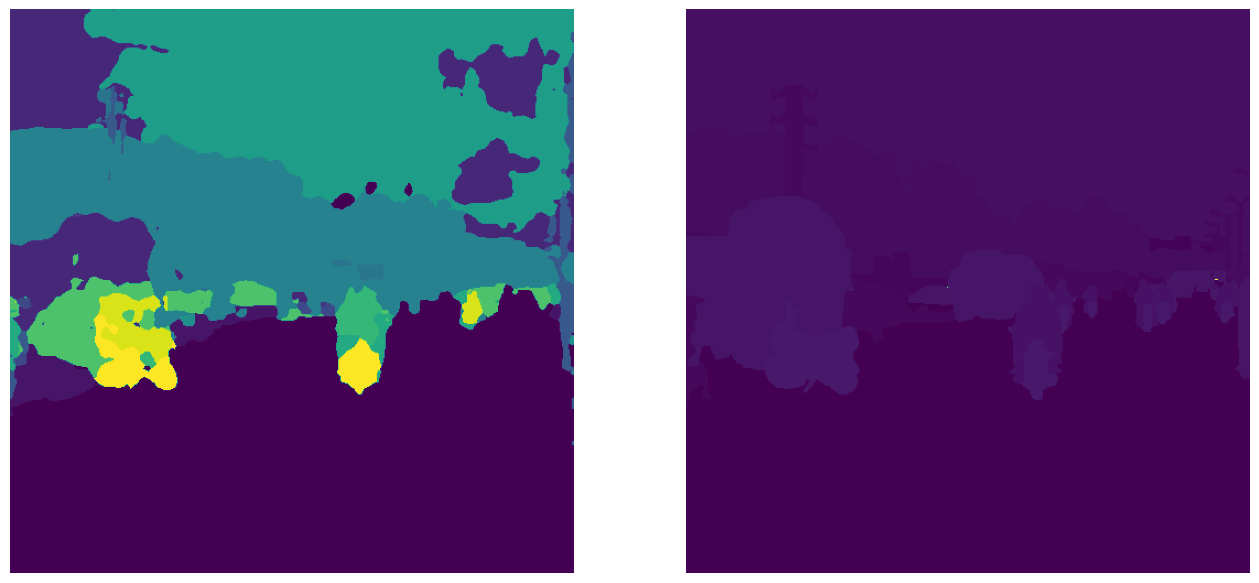

[0.96463063 0.         0.46204606 0.         0.         0.19415066
 0.         0.16705029 0.45866197 0.         0.75190338 0.11460102
 0.         0.72413909 0.         0.03481894 0.         0.00112962
 0.        ]


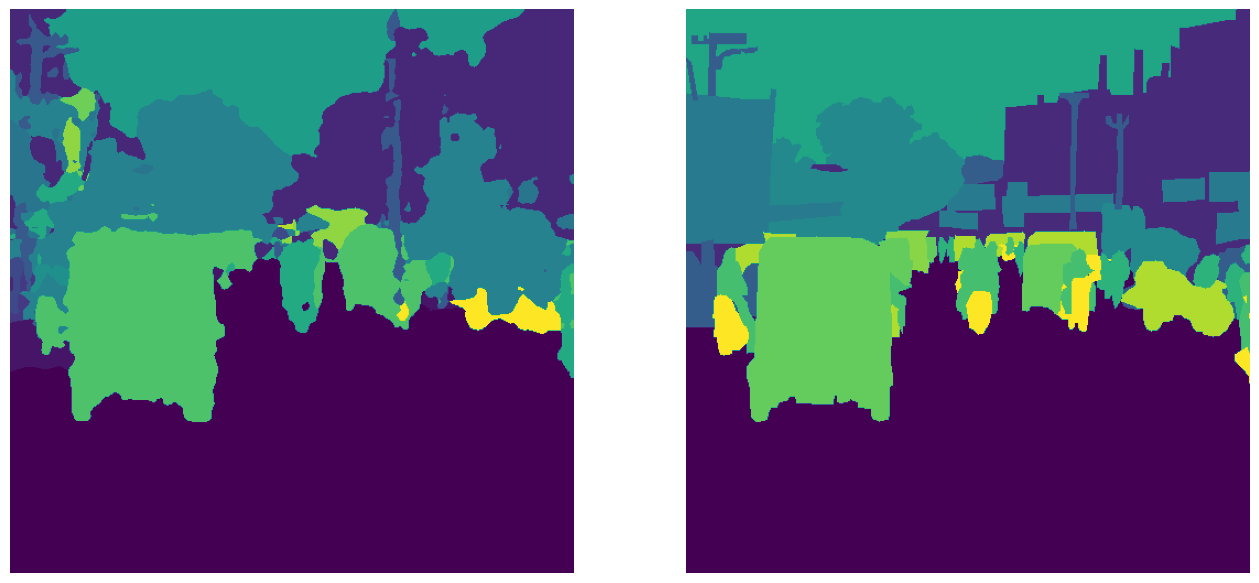

[0.94393256 0.         0.32741589 0.         0.         0.01343075
 0.         0.05132801 0.59770648 0.         0.         0.05615818
 0.19658601 0.44526502 0.         0.         0.         0.26736547
 0.        ]


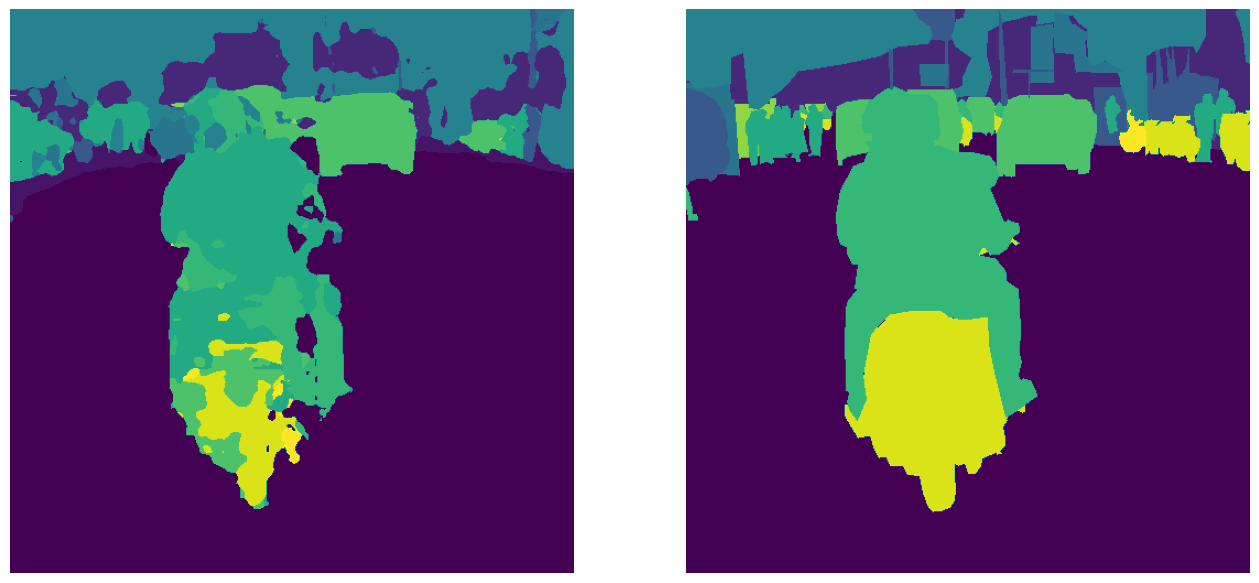

[0.93399142 0.         0.07008597 0.         0.         0.05032564
 0.         0.00273224 0.74993069 0.         0.86955115 0.12956335
 0.25881431 0.70527081 0.         0.         0.         0.34015091
 0.        ]


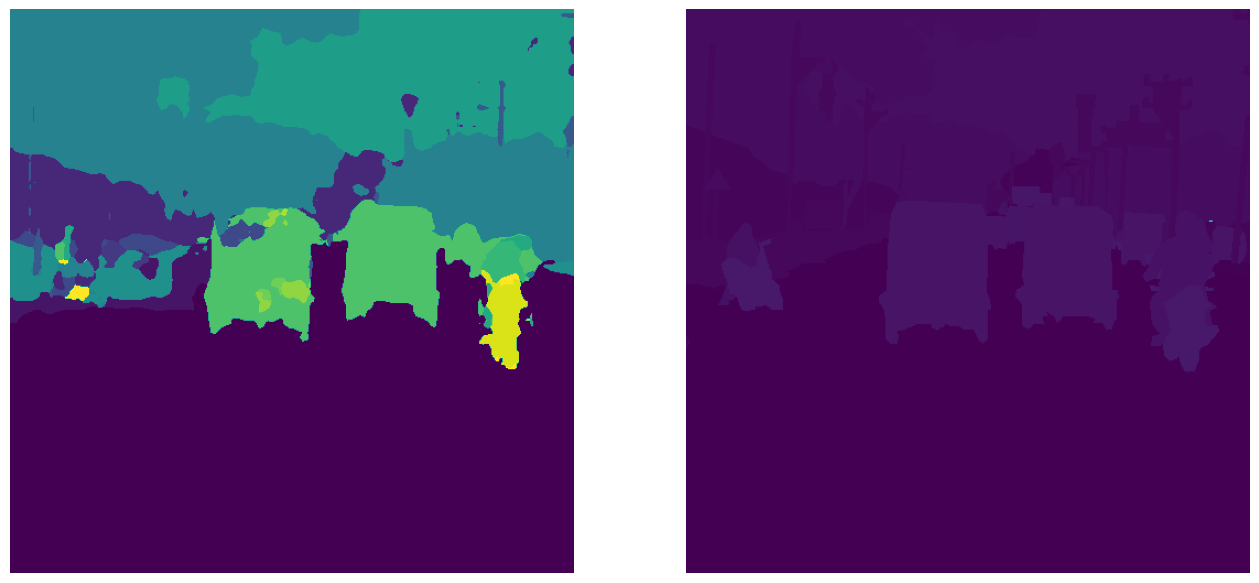

In [16]:
y_pred = []
y_true = []

for image, label in test_loader:
    flag = False
    if(num_counter>=100):
        break
    with torch.no_grad():
        outputs = model(image)
    preds = outputs.max(1)[1].detach().numpy()
    labels = label.numpy()
    if(num_counter<6):
        flag = True
    metric_func(preds[0],labels[0],flag)
    metric_func(preds[1],labels[1],flag)
    y_pred.append(preds[0])
    y_true.append(labels[0])
    y_pred.append(preds[1])
    y_true.append(labels[1])
    del image, labels, outputs
    gc.collect()

In [17]:
print('Performance')

print('Pixel Wise Accuracy: ', pixel_accuracy/num_counter*100)
print('Dice Coefficient Accuracy: ', dice_coeff/num_counter)
print('mAP', total_mAP/num_counter*100)


Performance
Pixel Wise Accuracy:  70.32626342773438
Dice Coefficient Accuracy:  8.240604122271472
mAP 26.397726824850682


In [18]:
print('Performance Class Wise for 100 images')
for i in range(19):
    if(i!=19):
        print(class_dict[i])
    else:
        print('Unlabelled')
    a, b = total_mIoU[i]
    if(b==0):
        print("mIoU:",'nan')
    else:
        print("mIoU:", a/b*100)

    a, b = total_recall[i]
    if(b==0):
        print("Recall:",'nan')
    else:
        print("Recall:", a/b*100)

    a, b = total_precision[i]
    if(b==0):
        print("Precision:",'nan')
    else:
        print("Precision:", a/b*100)

Performance Class Wise for 100 images
road
mIoU: 82.42217267787252
Recall: 92.3127596504886
Precision: 87.3766415194709
sidewalk
mIoU: 18.72542975195665
Recall: 55.88479449754067
Precision: 27.90368032107794
building
mIoU: 31.08035052903769
Recall: 64.95783207568931
Precision: 37.6027852128262
wall
mIoU: 18.409778249747447
Recall: 23.01936136432923
Precision: 63.33779929919125
fence
mIoU: 13.213006909229128
Recall: 17.56196596422309
Precision: 30.46016708177348
pole
mIoU: 16.245416371429638
Recall: 20.15515396721311
Precision: 53.76408906777782
traffic light
mIoU: 0.529801324496294
Recall: 0.529801324496294
Precision: 99.99999975
traffic sign
mIoU: 19.725913082894518
Recall: 27.557732453696037
Precision: 51.9447665758166
vegetation
mIoU: 65.43430441513637
Recall: 87.24485634788296
Precision: 72.97863037301278
terrain
mIoU: 11.520996708815806
Recall: 31.521793121826736
Precision: 22.877165467576077
sky
mIoU: 56.84288994968577
Recall: 58.636024399696495
Precision: 96.72224712552303
perso

I have done for 10 images, because for images where masks are not changing the color there is some class mismatch for the rest of the images
Where things are going well. The objects are occluded they are many classes together and hence it is not able to distinguish between the closer classes
whereas there is no perfect boundary or match of colors. Also environment sometimes hinder with the main object

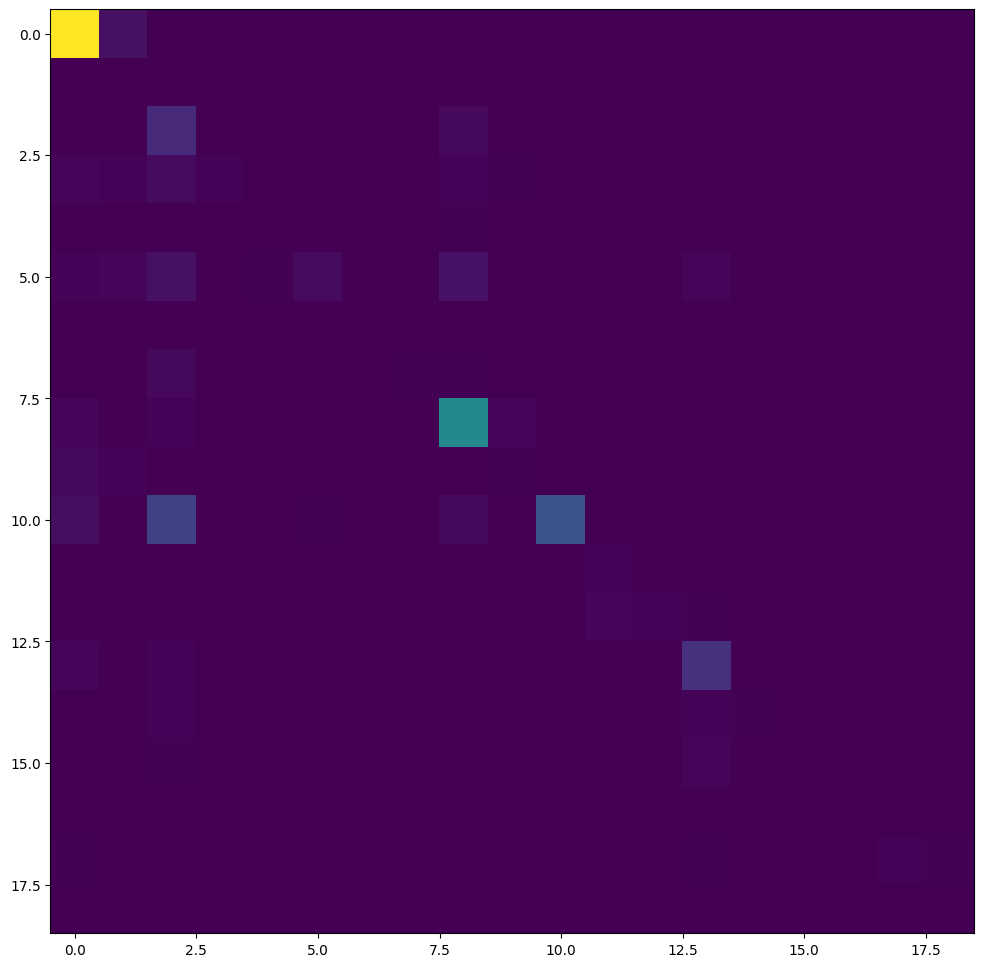

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(16,12))
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
cm = confusion_matrix(y_true, y_pred, labels=range(19))
plt.imshow(cm, cmap='viridis')
plt.show(plt)

Performance Class Wise for 100 images
road
mIoU: 82.42217267787252
Recall: 92.3127596504886
Precision: 87.3766415194709
sidewalk
mIoU: 18.72542975195665
Recall: 55.88479449754067
Precision: 27.90368032107794
building
mIoU: 31.08035052903769
Recall: 64.95783207568931
Precision: 37.6027852128262
wall
mIoU: 18.409778249747447
Recall: 23.01936136432923
Precision: 63.33779929919125
fence
mIoU: 13.213006909229128
Recall: 17.56196596422309
Precision: 30.46016708177348
pole
mIoU: 16.245416371429638
Recall: 20.15515396721311
Precision: 53.76408906777782
traffic light
mIoU: 0.529801324496294
Recall: 0.529801324496294
Precision: 99.99999975
traffic sign
mIoU: 19.725913082894518
Recall: 27.557732453696037
Precision: 51.9447665758166
vegetation
mIoU: 65.43430441513637
Recall: 87.24485634788296
Precision: 72.97863037301278
terrain
mIoU: 11.520996708815806
Recall: 31.521793121826736
Precision: 22.877165467576077
sky
mIoU: 56.84288994968577
Recall: 58.636024399696495
Precision: 96.72224712552303
person
mIoU: 25.32109922115006
Recall: 48.57782573772026
Precision: 35.414530979376174
rider
mIoU: 24.914207328683524
Recall: 29.968800665314042
Precision: 62.40342889168341
car
mIoU: 53.99427147350683
Recall: 76.02616362772031
Precision: 63.4582249139821
truck
mIoU: 12.27627589551336
Recall: 13.392941156234613
Precision: 55.291889613726205
bus
mIoU: 15.223888295687646
Recall: 15.701346785851655
Precision: 68.87702615748427
train
mIoU: nan
Recall: nan
Precision: nan
motorcycle
mIoU: 26.442621066648975
Recall: 38.07007269506526
Precision: 60.5832728030119
bicycle
mIoU: 4.115646354030071
Recall: 55.17378826023583
Precision: 4.233751092343527

The confusion matrix as heatmap shows the good understading of the road class. There is a little heats for class vegetation, sky, and car based on their diagnol color understading well amount of class. For other blue patches outside of the diagnols there is confusion. Some of it is based on the model efficiency while some of it is due to the
change of labels I have manually done in order to change the number of class from 26 to 19. As the mobile net is trained on 19 classes.

When can also see the same analysis of results from the precision, recall and F1 score of different classes. We can see classes road, vegetation, sky, car are very well classified which we can see from the printed results as well. For classes bicycle, traffic light and terrain we can train on the IDD for better results. Please refer to the performance metrics above for each class.